In [1]:
!wget https://s3.eu-central-1.amazonaws.com/ilia-ml-stuff/mnist-hw1.pkl

--2019-03-28 05:04:44--  https://s3.eu-central-1.amazonaws.com/ilia-ml-stuff/mnist-hw1.pkl
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.72.131
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.72.131|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 164640241 (157M) [application/x-www-form-urlencoded]
Saving to: ‘mnist-hw1.pkl’

mnist-hw1.pkl       100%[===================>] 157,01M  9,95MB/s    in 17s     

2019-03-28 05:05:01 (9,15 MB/s) - ‘mnist-hw1.pkl’ saved [164640241/164640241]



In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [17]:
run = 0

In [3]:
def mask(size, type_A):
    m = np.zeros((size, size), dtype=np.float32)
    m[:size//2, :] = 1
    m[size//2, :size//2] = 1
    if not type_A:
        m[size//2, size//2] = 1
    return m

def conv_masked(inp, name, size, in_channels=128, out_channels=128, type_A=False):
    conv_filter = tf.get_variable(name=name + '_filter',
                                  shape=(size, size, in_channels, out_channels), 
                                  trainable=True)
    conv_bias = tf.get_variable(name=name + '_bias',
                                shape=(inp.shape[1].value, inp.shape[2].value, out_channels),
                                trainable=True)

    masked_conv_filter = conv_filter * mask(size, type_A)[:, :, np.newaxis, np.newaxis]
    return tf.nn.conv2d(inp, masked_conv_filter, strides=[1, 1, 1, 1], padding='SAME',
                       name=name) + conv_bias

def conv_1x1(inp, name, in_channels, out_channels):
    conv_filter = tf.get_variable(name=name + '_filter',
                                 shape=(1, 1, in_channels, out_channels),
                                 trainable=True)
    conv_bias = tf.get_variable(name=name + '_bias',
                            shape=(inp.shape[1].value, inp.shape[2].value, out_channels),
                            trainable=True)
    return tf.nn.conv2d(inp, conv_filter, strides=[1, 1, 1, 1], padding='SAME', name=name) + conv_bias

def res_block(inp, scope, channels=128):
    with tf.variable_scope(scope):
        res = tf.nn.relu(inp)
        res = conv_1x1(res, 'conv1x1_downsample', channels, channels // 2)
        res = tf.nn.relu(res)
        res = conv_masked(res, 'conv3x3', 3, channels // 2, channels // 2)
        res = tf.nn.relu(res)
        res = conv_1x1(res, 'conv1x1_upsample', channels // 2, channels)
        
        return inp + res

In [4]:
with open('mnist-hw1.pkl', 'rb') as fp:
    data = pickle.load(fp)

In [5]:
def pixel_cnn(inp, scope, channels, final_channels):
    with tf.variable_scope(scope):
        net = conv_masked(inp, name='start_conv7x7', size=7, in_channels=3, 
                          out_channels=channels, type_A=True)

        for i in range(12):
            net = res_block(net, scope='res_block_{}'.format(i+1), 
                            channels=channels)

        net = conv_masked(net, 'final_conv3x3', size=3, 
                          in_channels=channels, 
                          out_channels=channels)
        net = tf.nn.relu(net)
        net = conv_1x1(net, 'final_conv1x1_1', 
                       in_channels=channels, 
                       out_channels=channels)
        net = tf.nn.relu(net)
        net = conv_1x1(net, 'final_conv1x1_2', 
                       in_channels=channels, 
                       out_channels=final_channels)
        return net

In [33]:
class MadeInput:
    def __init__(self, scope, inp, depth):
        with tf.variable_scope(scope):
            self.width = inp.shape[1].value
            self.height = inp.shape[2].value
            self.D = inp.shape[3].value
            self.depth = depth
            
            self.units = tf.reshape(
                tf.one_hot(inp, depth=self.depth, dtype=tf.float32),
                shape=(tf.shape(inp)[0],
                       self.width,
                       self.height,
                       self.depth * self.D))
            self.m = np.arange(self.D)
            self.m = np.repeat(self.m, self.depth, axis=-1)
        
class MadeHiddenWithAuxiliary:
    def __init__(self, scope, made_prev_layer, auxiliary, unit_count):
        with tf.variable_scope(scope):
            self.width = made_prev_layer.width
            self.height = made_prev_layer.height
            self.D = made_prev_layer.D
            self.depth = made_prev_layer.depth
            
            self.m = np.mod(np.arange(unit_count), self.D - 1)
            
            self.units = tf.concat([made_prev_layer.units, auxiliary], axis=-1)
            ext_input_length = made_prev_layer.m.shape[-1] + auxiliary.shape[-1].value
            
            self.weight_mask = np.ones((unit_count,
                                       ext_input_length),
                                       dtype=np.bool)
            self.weight_mask[:self.m.shape[-1], 
                             :made_prev_layer.m.shape[-1]] = self.m[:, np.newaxis] >= made_prev_layer.m[np.newaxis, :]
            self.W = tf.get_variable("W", shape=(self.width,
                                                 self.height,
                                                 unit_count, 
                                                 ext_input_length))
            self.b = tf.get_variable("b", 
                                     shape=(self.width,
                                            self.height,
                                            unit_count))
            
            self.units = tf.einsum('whij,bwhj->bwhi', self.W * self.weight_mask, self.units) + self.b
            self.units = tf.nn.relu(self.units)
        
class MadeHidden:
    def __init__(self, scope, made_prev_layer, unit_count):
        with tf.variable_scope(scope):
            self.width = made_prev_layer.width
            self.height = made_prev_layer.height
            self.D = made_prev_layer.D
            self.depth = made_prev_layer.depth
            
            self.m = np.mod(np.arange(unit_count), self.D - 1)

            self.weight_mask = self.m[:, np.newaxis] >= made_prev_layer.m[np.newaxis, :]
            self.W = tf.get_variable("W", shape=(self.width,
                                                 self.height,
                                                 unit_count, 
                                                 made_prev_layer.m.shape[-1]))
            self.b = tf.get_variable("b", shape=(self.width,
                                                 self.height,
                                                 unit_count))
            
            self.units = tf.einsum('whij,bwhj->bwhi', self.W * self.weight_mask,
                                   made_prev_layer.units) + self.b
            self.units = tf.nn.relu(self.units)

class MadeOutput:
    def __init__(self, scope, made_input_layer, made_prev_layer, auxiliary):
        with tf.variable_scope(scope):
            self.width = made_prev_layer.width
            self.height = made_prev_layer.height
            self.D = made_prev_layer.D
            self.depth = made_prev_layer.depth
            
            self.m = np.repeat(np.arange(self.D), self.depth)
            self.weight_mask = self.m[:, np.newaxis] > made_prev_layer.m[np.newaxis, :]
            self.W = tf.get_variable("W", shape=(self.width,
                                                 self.height,
                                                 self.D * self.depth, 
                                                 made_prev_layer.m.shape[-1]))
            self.b = tf.get_variable("b", shape=(self.width,
                                                 self.height,
                                                 self.D * self.depth))
            
            self.direct_mask = np.repeat(np.tril(np.ones(self.D), -1), self.depth).reshape((self.D, -1))
            self.direct_mask = np.repeat(self.direct_mask, self.depth, axis=0)
            self.A = tf.get_variable("A", shape=(self.width, 
                                                 self.height,
                                                 self.D * self.depth, 
                                                 self.D * self.depth))
            
            self.units = tf.einsum('whij,bwhj->bwhi', 
                                   self.W * self.weight_mask, 
                                   made_prev_layer.units) + self.b
            self.units += tf.einsum('whij,bwhj->bwhi',  
                                    self.A * self.direct_mask,
                                    made_input_layer.units)
            
            self.unconnected_W = tf.get_variable('unconnected_W',
                                                shape=(self.width,
                                                       self.height,
                                                       self.depth,
                                                       auxiliary.shape[-1].value))
            self.unconnected_b = tf.get_variable('unconnected_b',
                                                shape=(self.width,
                                                       self.height,
                                                       self.depth))
            self.unconnected_out = tf.einsum('whij,bwhj->bwhi',
                                            self.unconnected_W,
                                            auxiliary) + self.unconnected_b
            self.units = tf.concat([self.unconnected_out, 
                                    self.units[:, :, :, self.depth:]],
                                   axis=3)
            self.units = tf.reshape(self.units, shape=(tf.shape(self.units)[0],
                                                       self.width,
                                                       self.height,
                                                       self.D,
                                                       self.depth))

In [34]:
tf.reset_default_graph()

batch_size = 128

train_dataset = tf.data.Dataset.from_tensor_slices(data['train'])
val_dataset = tf.data.Dataset.from_tensor_slices(data['test'])

train_it = train_dataset.shuffle(256).batch(batch_size).make_initializable_iterator()
val_it = val_dataset.shuffle(256).batch(batch_size).make_initializable_iterator()

dataset_handle = tf.placeholder(tf.string, shape=())
iterator = tf.data.Iterator.from_string_handle(dataset_handle, 
                                               output_types=train_it.output_types,
                                               output_shapes=train_it.output_shapes)

next_element = iterator.get_next()

inp = next_element
net = tf.multiply(tf.cast(inp, tf.float32), 1./3.)
net = tf.identity(net, 'preprocessed_input')
net = pixel_cnn(net, scope='pixel_cnn', channels=128, final_channels=16)
net = tf.nn.relu(net)
tf.summary.histogram('pixel_cnn_embedding', net)

made_input = MadeInput('made_input', inp, depth=4)
made_hidden_1 = MadeHiddenWithAuxiliary('made_h1_with_aux', made_input, net, 32)
tf.summary.histogram('made_hidden_1', made_hidden_1.units)
made_out = MadeOutput('made_out', made_input, made_hidden_1, net)
softmaxed = tf.nn.softmax(made_out.units, axis=-1)
tf.summary.histogram('softmaxed', softmaxed)

<tf.Tensor 'softmaxed:0' shape=() dtype=string>

In [35]:
unreduced_loss = tf.nn.softmax_cross_entropy_with_logits_v2(tf.one_hot(inp, depth=4),
                                                  made_out.units,
                                                  axis=-1) * np.log2(np.e)
tf.summary.histogram('unreduced_loss', unreduced_loss)
loss = tf.reduce_mean(unreduced_loss)

In [36]:
global_step = tf.train.get_or_create_global_step()

In [37]:
opt = tf.train.AdamOptimizer(learning_rate=0.001)
grads_and_vars = opt.compute_gradients(loss)
for grad, var in grads_and_vars:
    tf.summary.histogram(grad.name.split(':')[0], grad)
    tf.summary.histogram(var.name.split(':')[0], var)

grads, variables = zip(*grads_and_vars)
grads, _ = tf.clip_by_global_norm(grads, 5)
for grad in grads:
    tf.summary.histogram(grad.name.split(':')[0] + '_clipped', grad)
                                        
train_step = opt.apply_gradients(zip(grads, variables), global_step=global_step)

In [38]:
val_loss_mean, val_loss_update = tf.metrics.mean(loss)

In [39]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())
train_handle, val_handle = sess.run([train_it.string_handle(), val_it.string_handle()])
step = sess.run(global_step)

In [40]:
train_losses = []
val_losses = []

In [41]:
def sample_image(batch_size):
    image = np.random.choice(4, size=(batch_size, 28, 28, 3)).astype(np.uint8)
    
    for i in range(28):
        for j in range(28):
            for k in range(3):
                prob_output = sess.run(softmaxed, 
                                   {inp: image})
                for b in range(batch_size):
                    image[b, i, j, k] = np.random.choice(4, p=prob_output[b, i, j, k])
            
    return image

In [42]:
summary_op = tf.summary.merge_all()

In [43]:
writer = tf.summary.FileWriter('log/{}'.format(run))
run += 1

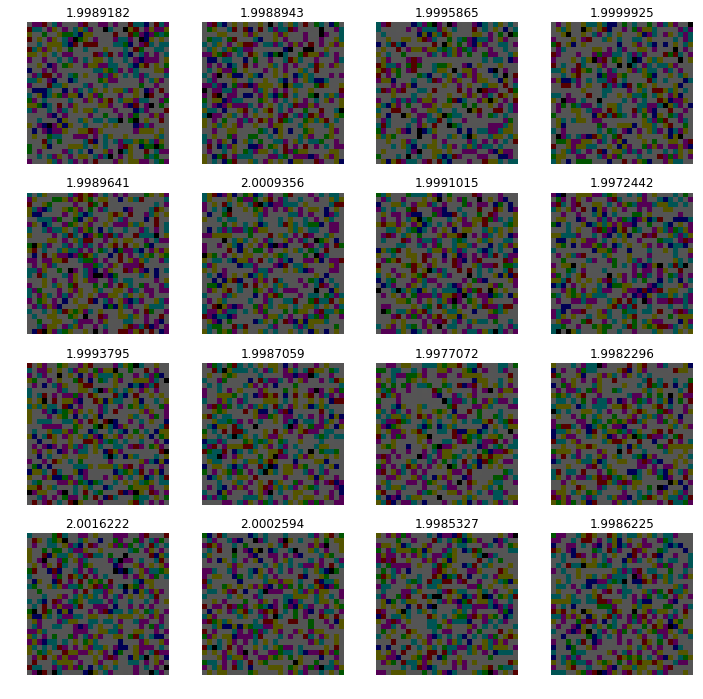

Epoch 0, step 468	train_loss: 0.33733201026916504
Epoch 0	 val_loss: 0.3323446214199066


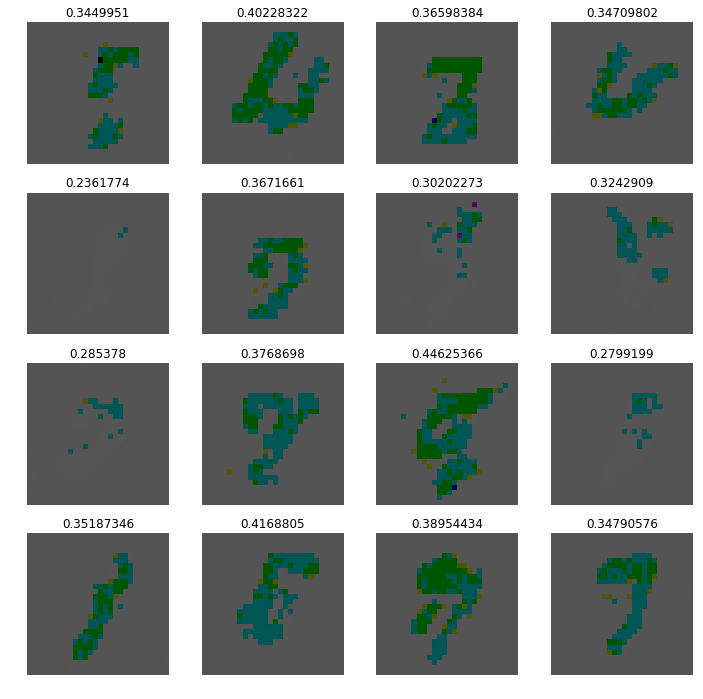

Epoch 1, step 937	train_loss: 0.2604397237300873
Epoch 1	 val_loss: 0.3018559217453003


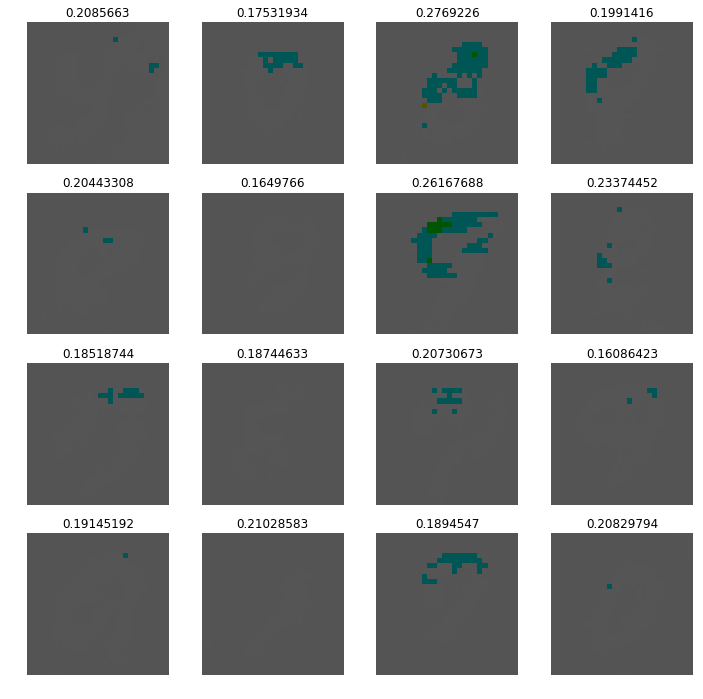

Epoch 2, step 1406	train_loss: 0.18290001153945923
Epoch 2	 val_loss: 0.2635864019393921


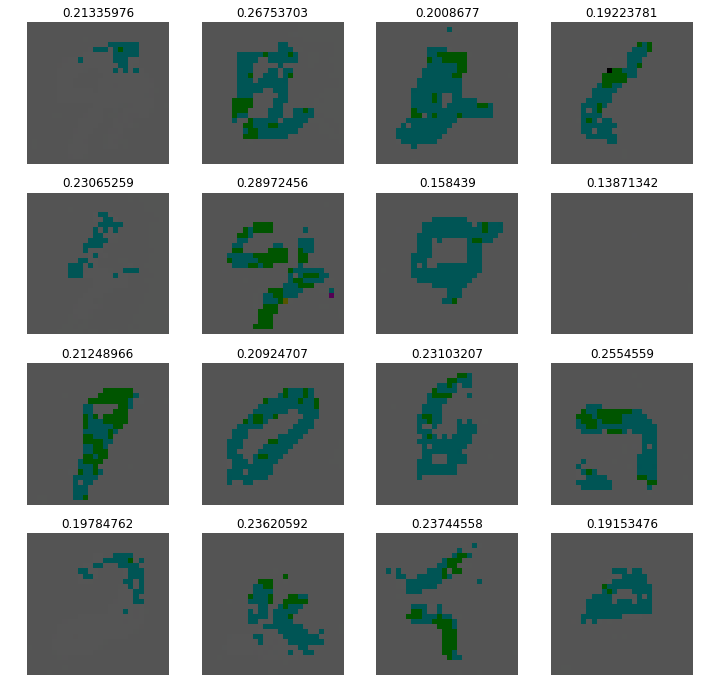

Epoch 3, step 1875	train_loss: 0.09287875890731812
Epoch 3	 val_loss: 0.22054904699325562


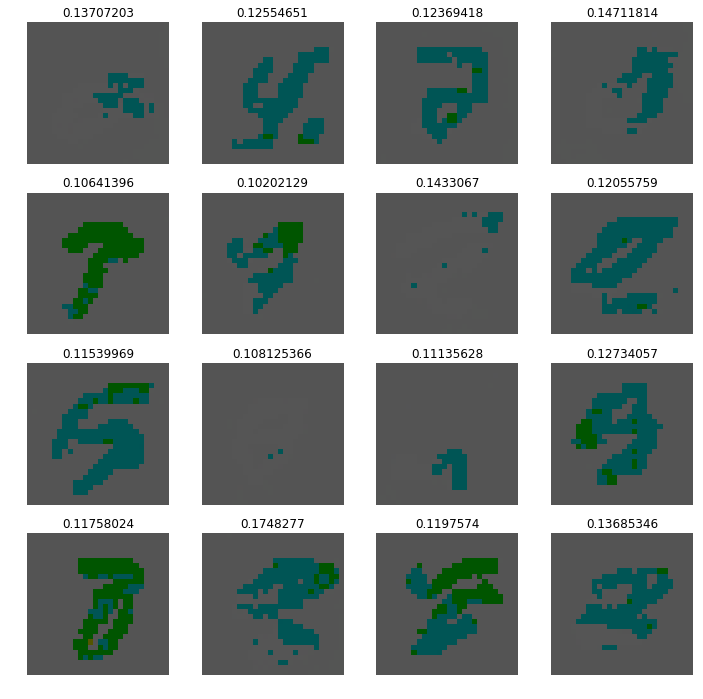

Epoch 4, step 2344	train_loss: 0.07321763783693314
Epoch 4	 val_loss: 0.19190561771392822


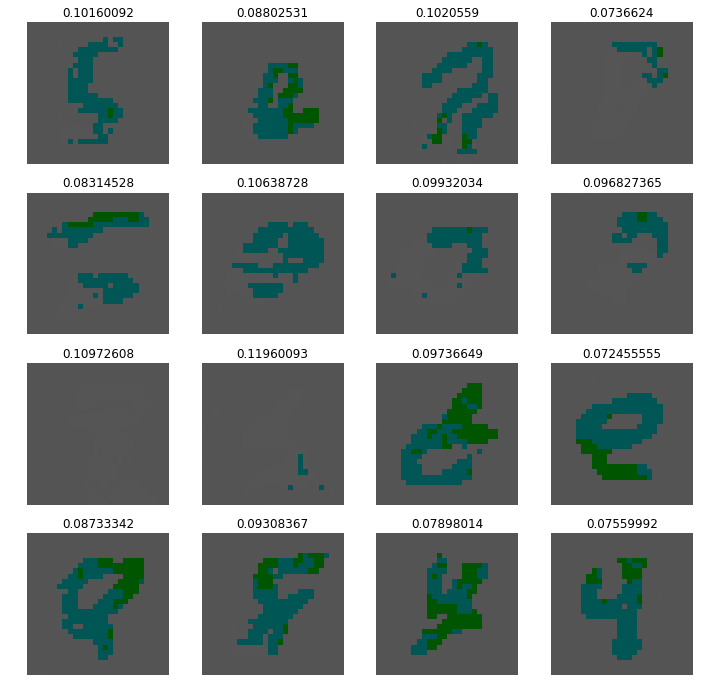

Epoch 5, step 2813	train_loss: 0.06951631605625153
Epoch 5	 val_loss: 0.1718713492155075


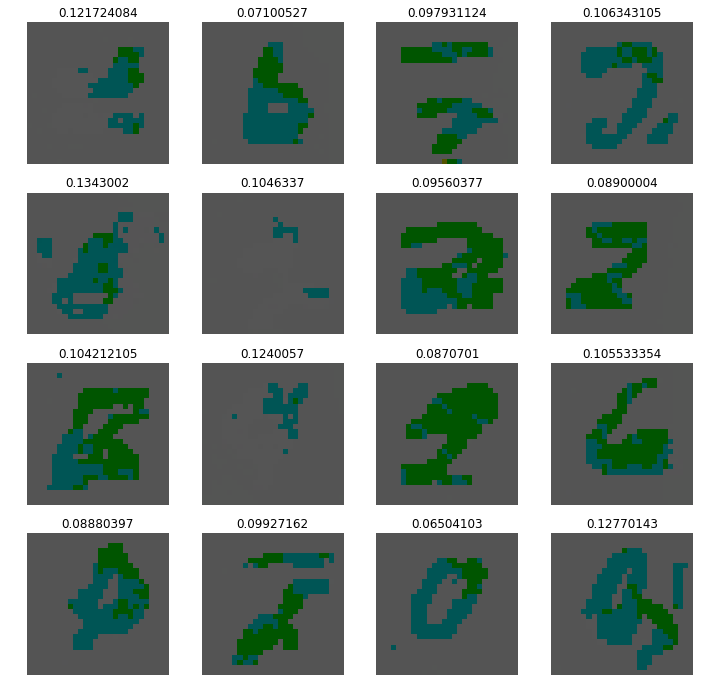

Epoch 6, step 3282	train_loss: 0.2965783476829529
Epoch 6	 val_loss: 0.19346274435520172


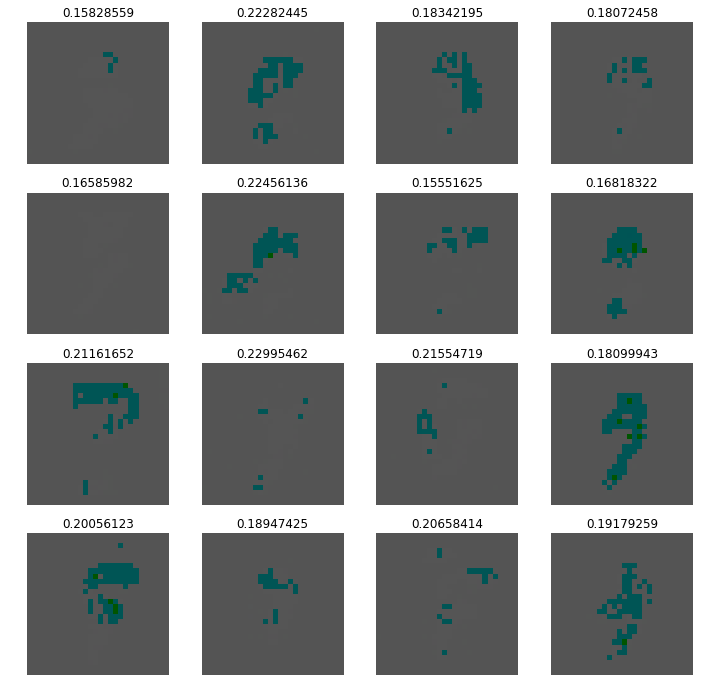

Epoch 7, step 3751	train_loss: 0.08667592704296112
Epoch 7	 val_loss: 0.18063819408416748


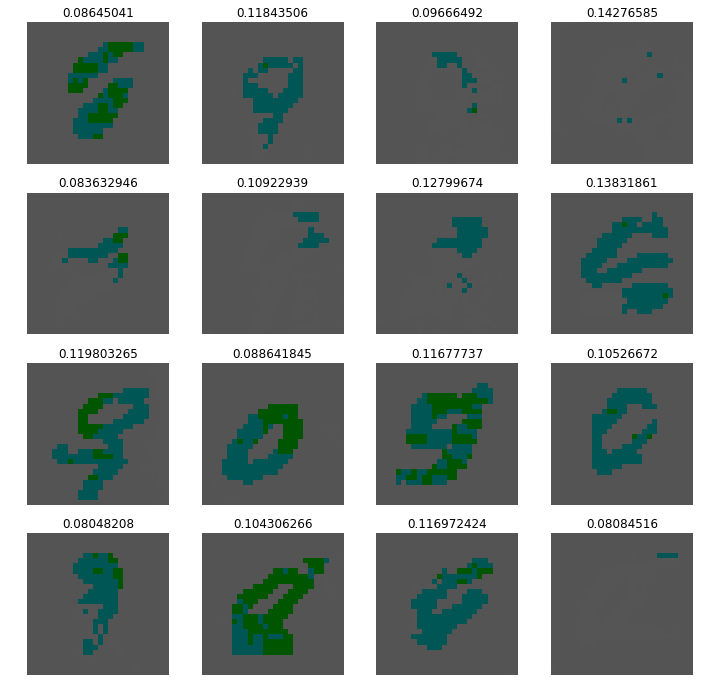

Epoch 8, step 4220	train_loss: 0.07309568673372269
Epoch 8	 val_loss: 0.1684899479150772


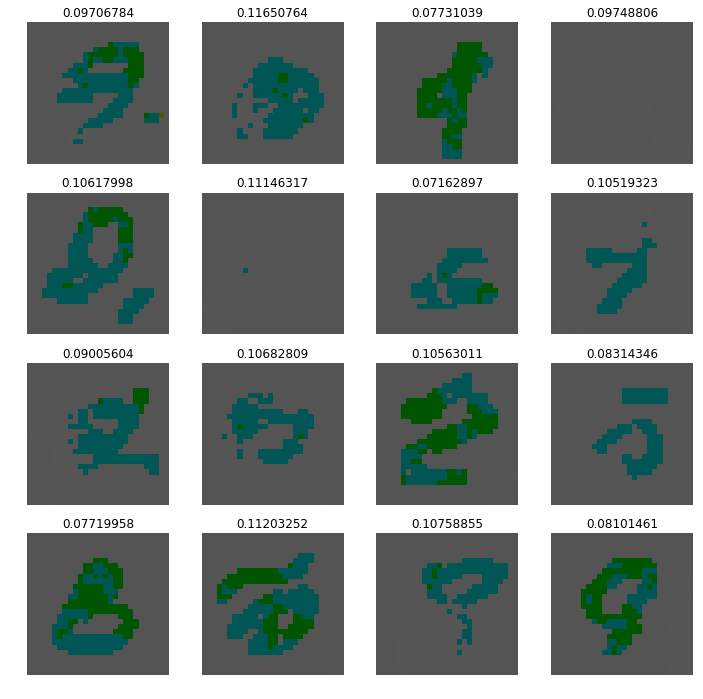

Epoch 9, step 4689	train_loss: 0.06417981535196304
Epoch 9	 val_loss: 0.158203586935997


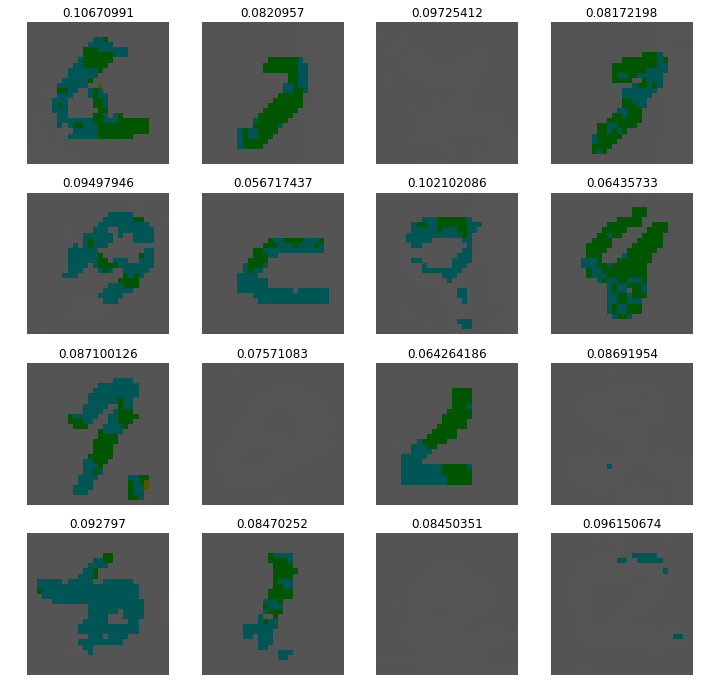

Epoch 10, step 5158	train_loss: 0.06372609734535217
Epoch 10	 val_loss: 0.1496092677116394


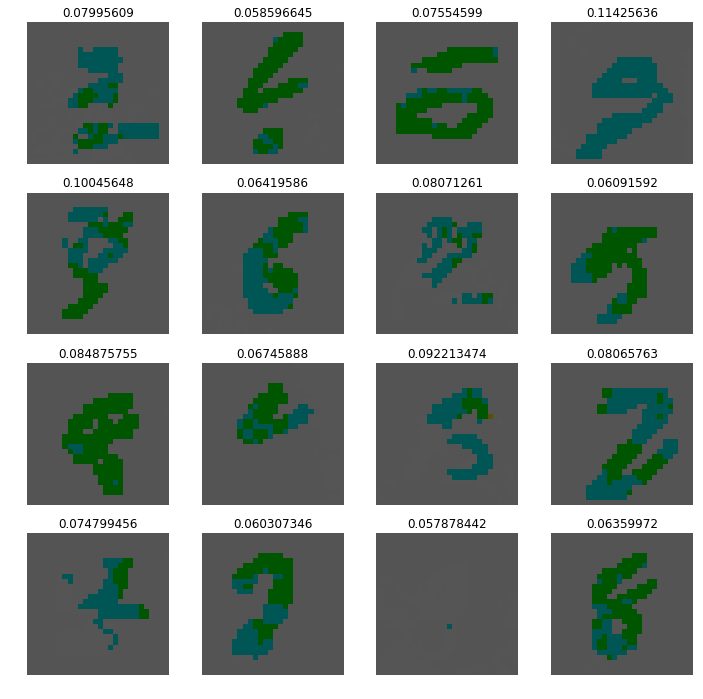

Epoch 11, step 5627	train_loss: 0.059835035353899
Epoch 11	 val_loss: 0.14224249124526978


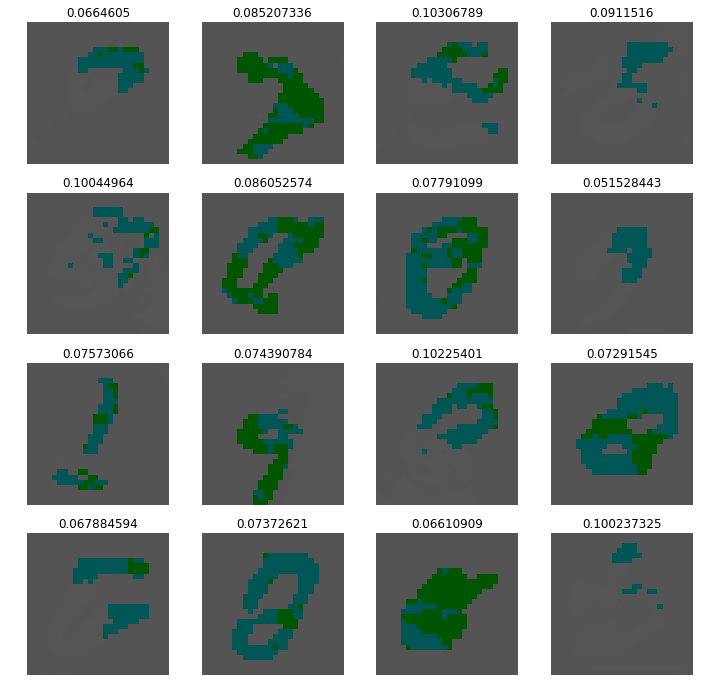

Epoch 12, step 6096	train_loss: 0.05916844680905342
Epoch 12	 val_loss: 0.13594304025173187


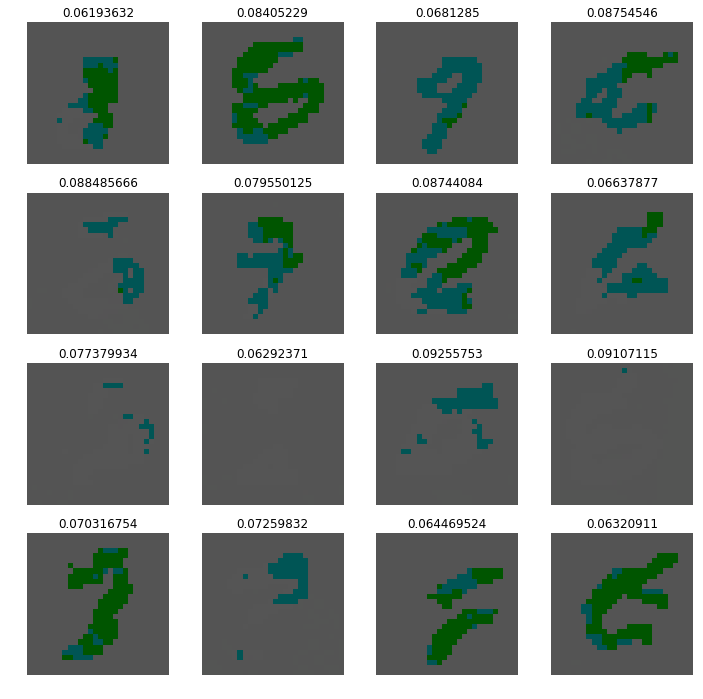

Epoch 13, step 6565	train_loss: 0.05779204145073891
Epoch 13	 val_loss: 0.13038237392902374


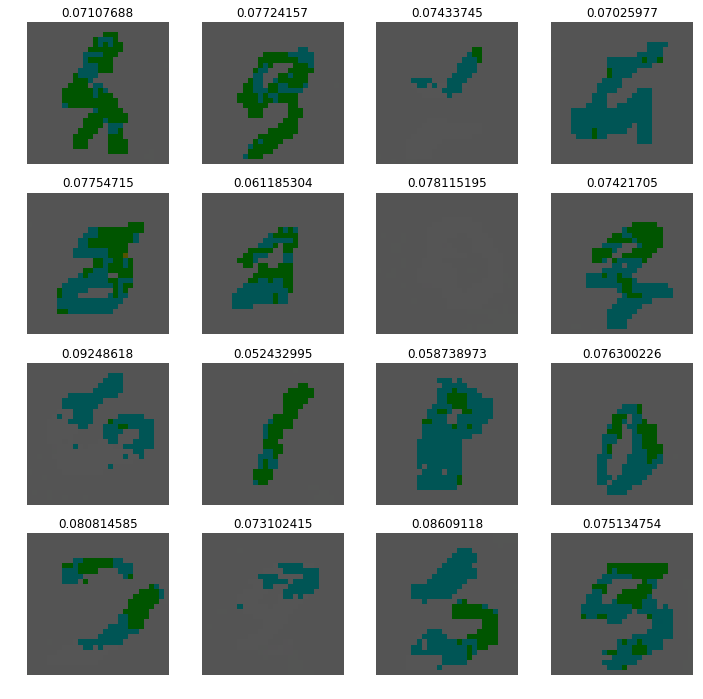

Epoch 14, step 7034	train_loss: 0.16266575455665588
Epoch 14	 val_loss: 0.13252025842666626


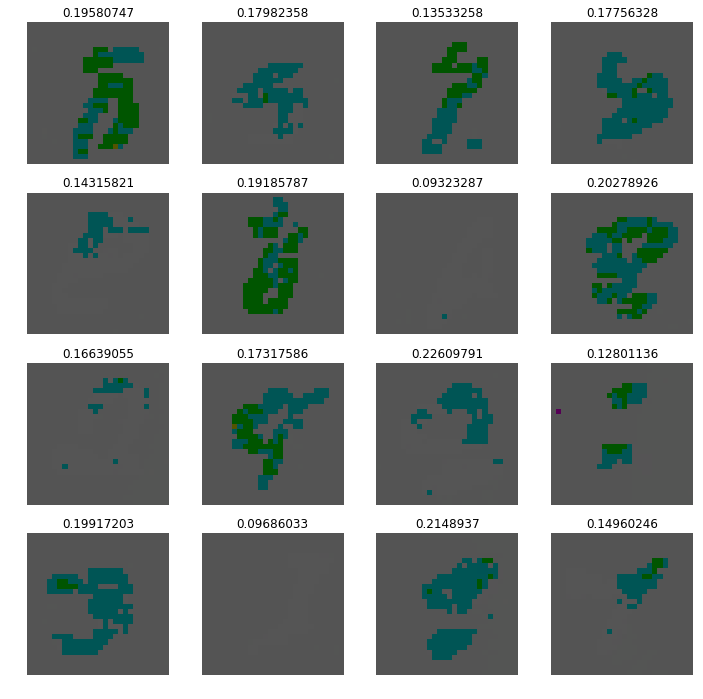

Epoch 15, step 7503	train_loss: 0.07384110242128372
Epoch 15	 val_loss: 0.12880074977874756


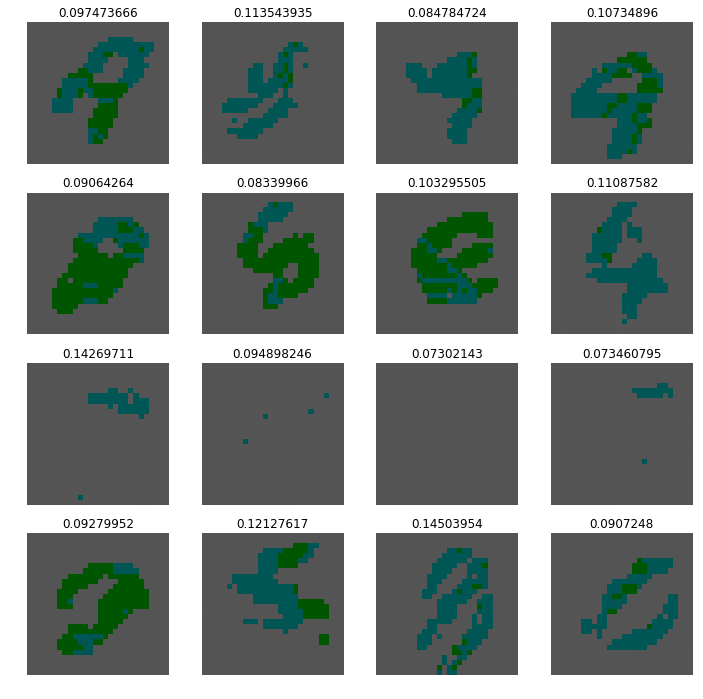

Epoch 16, step 7972	train_loss: 0.06316009908914566
Epoch 16	 val_loss: 0.12499502301216125


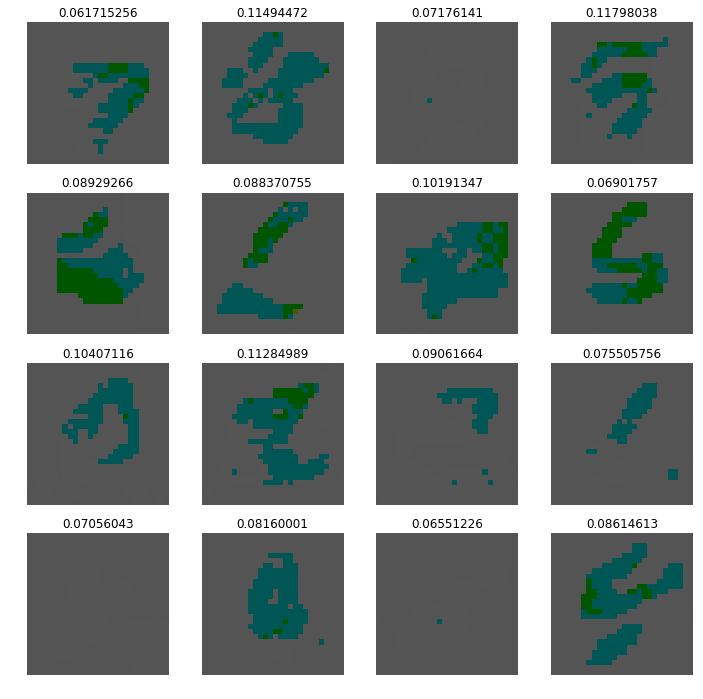

Epoch 17, step 8441	train_loss: 0.06112615391612053
Epoch 17	 val_loss: 0.1214234009385109


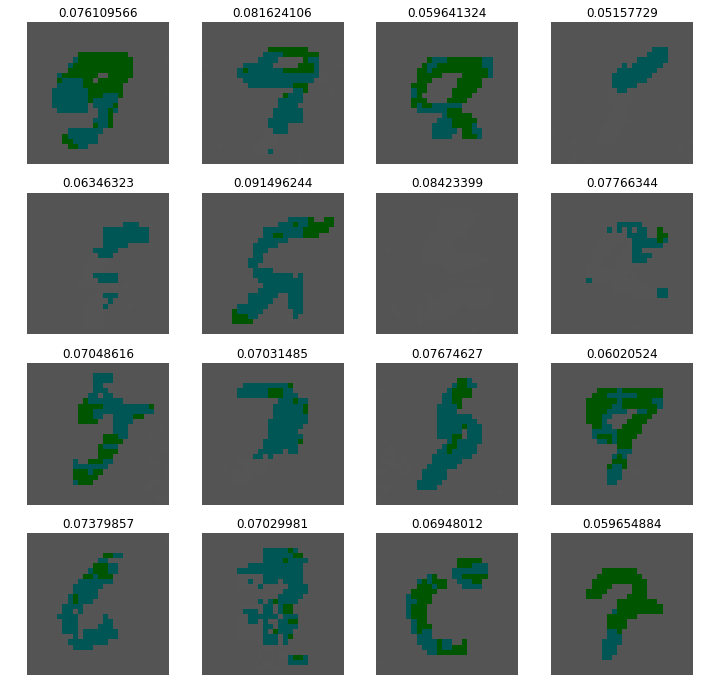

Epoch 18, step 8910	train_loss: 0.05687842145562172
Epoch 18	 val_loss: 0.11810321360826492


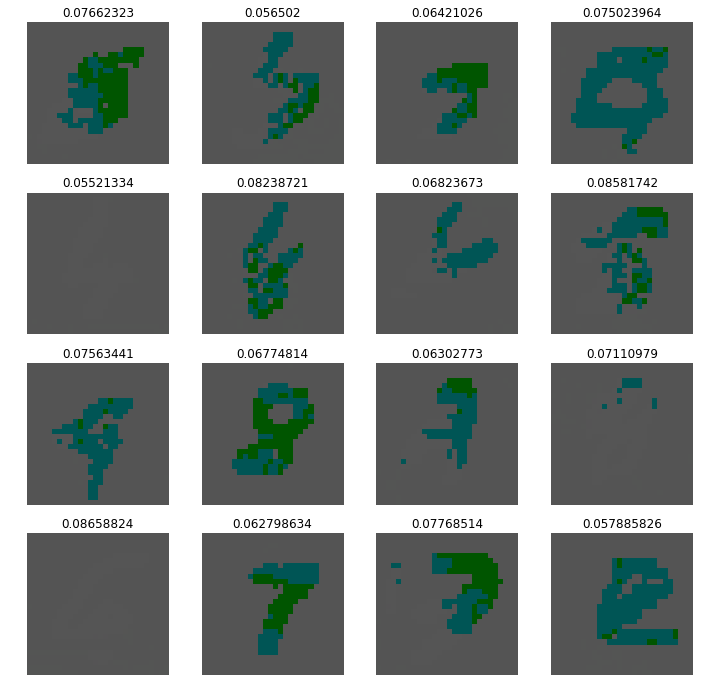

Epoch 19, step 9379	train_loss: 0.057236287742853165
Epoch 19	 val_loss: 0.11509081721305847


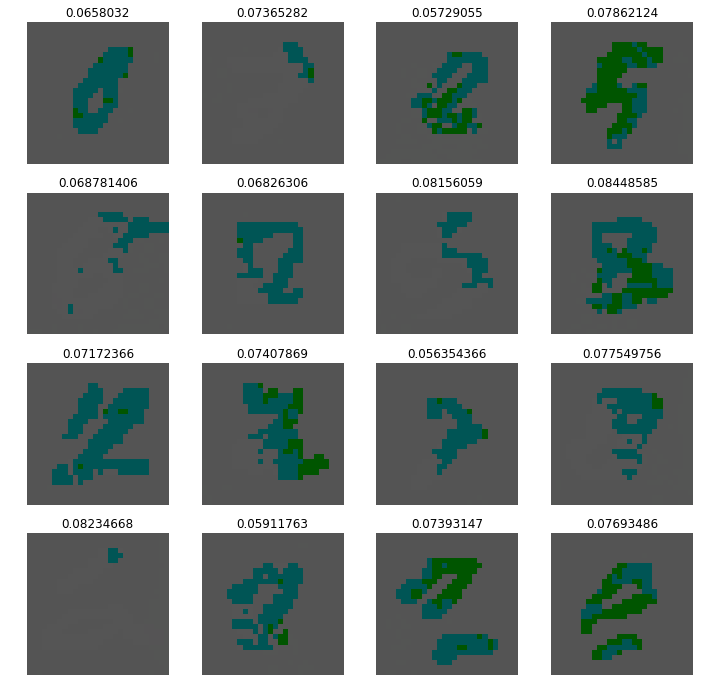

Epoch 20, step 9848	train_loss: 0.22783814370632172
Epoch 20	 val_loss: 0.12005796283483505


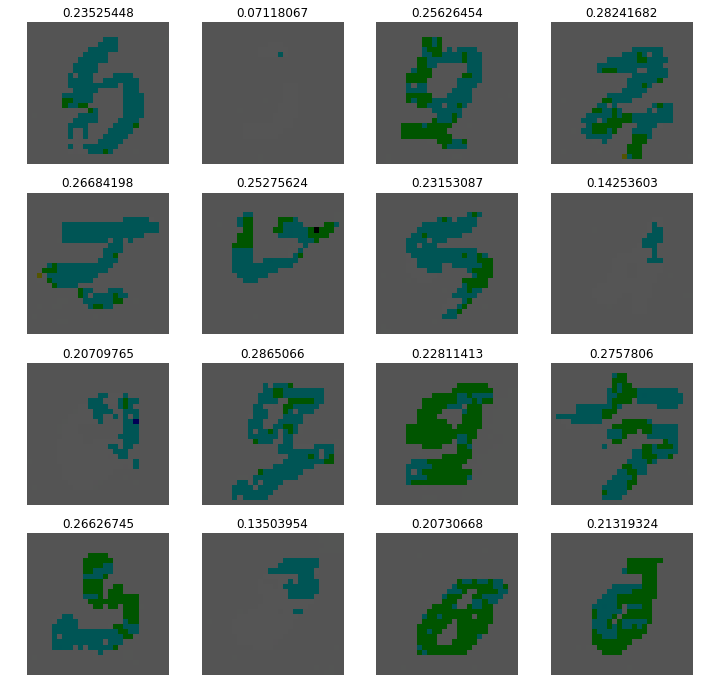

Epoch 21, step 10317	train_loss: 0.07033319026231766
Epoch 21	 val_loss: 0.11784764379262924


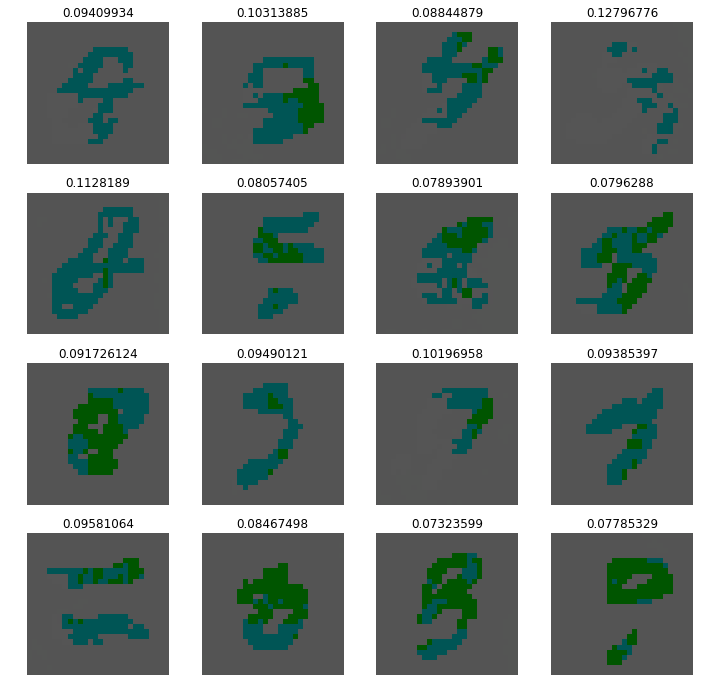

Epoch 22, step 10786	train_loss: 0.06249992176890373
Epoch 22	 val_loss: 0.11540047824382782


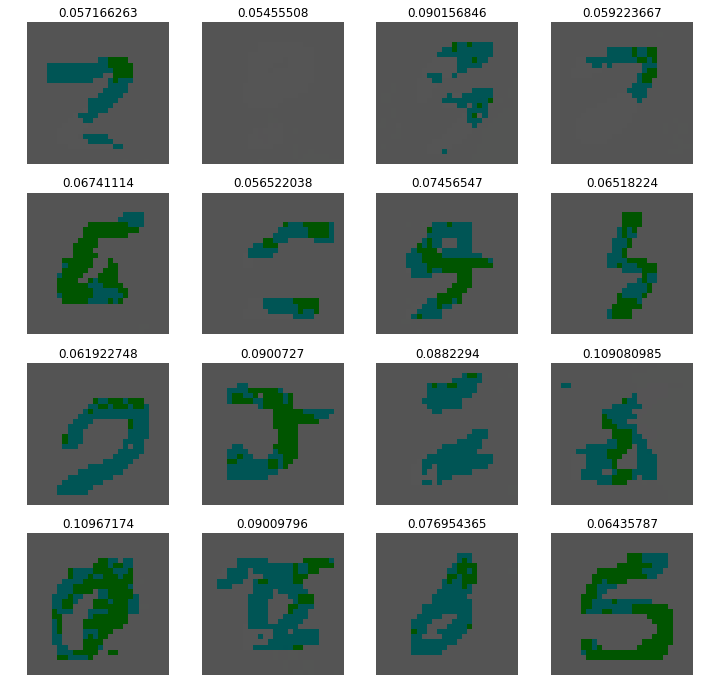

Epoch 23, step 11255	train_loss: 0.05864514783024788
Epoch 23	 val_loss: 0.11302560567855835


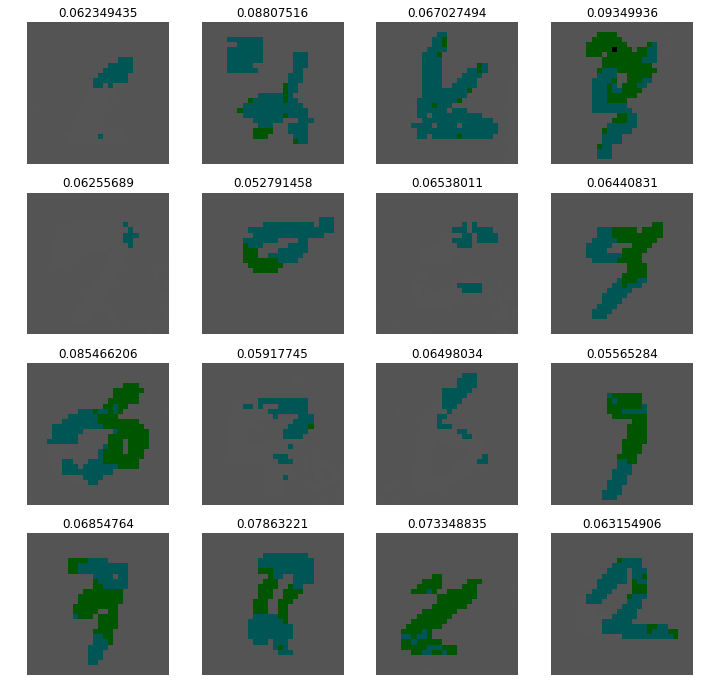

Epoch 24, step 11724	train_loss: 0.055380430072546005
Epoch 24	 val_loss: 0.11076492071151733


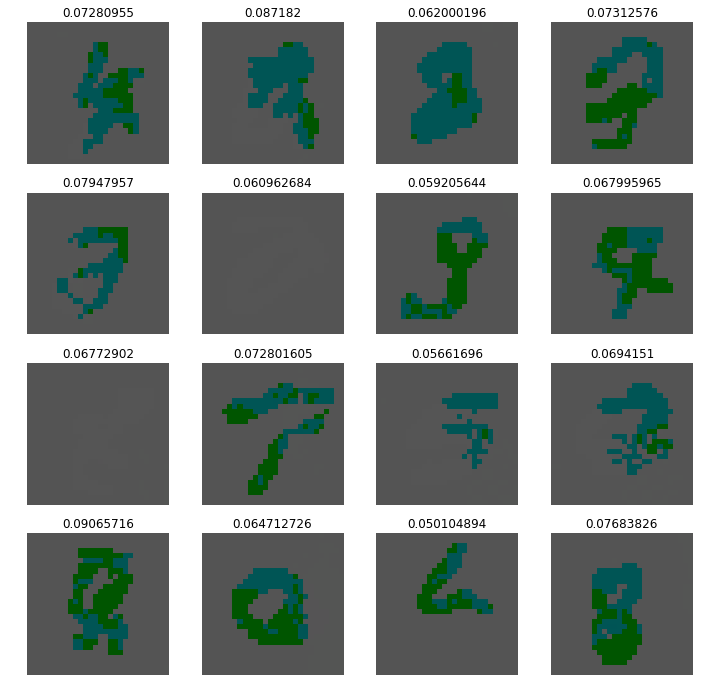

Epoch 25, step 12193	train_loss: 0.05467584729194641
Epoch 25	 val_loss: 0.10863577574491501


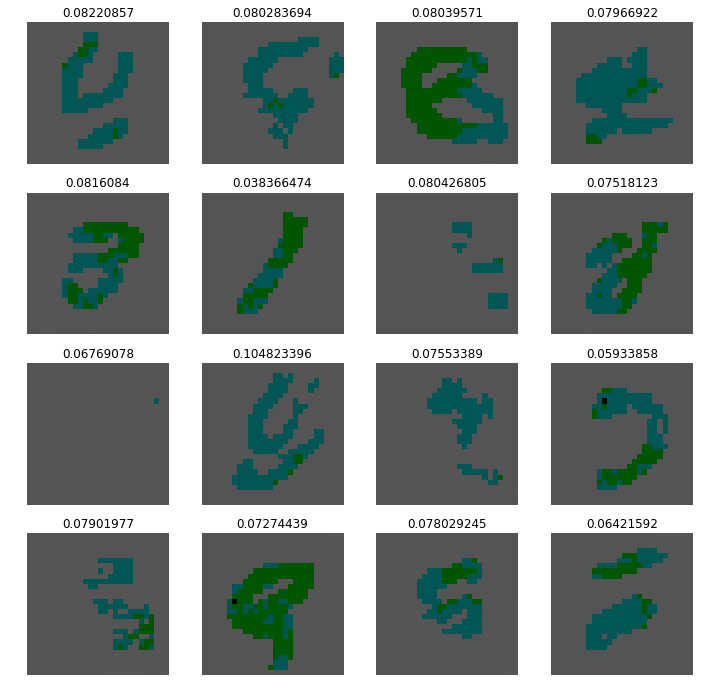

Epoch 26, step 12421	train_loss: 0.05401189625263214

KeyboardInterrupt: 

In [44]:
for i in range(50):  
    sess.run(train_it.initializer)
    
    plt.figure(figsize=(12, 12))
    img = sample_image(16)
    losses = sess.run(unreduced_loss, {inp: img})
    losses = losses.reshape(len(losses), -1)
    losses = np.mean(losses, axis=1)
    
    for k in range(4):
        for l in range(4):
            plt.subplot(4, 4, 4 * k + l + 1)        
            plt.imshow(img[4 * k + l] * 255 // 3)
            plt.axis('off')
            plt.grid(False)
            plt.title(losses[4 * k + l])
    plt.show()

    while True:
        try:
            _, loss_result, step = sess.run([train_step, loss, global_step], 
                                     {dataset_handle: train_handle})
            print('\rEpoch {}, step {}\ttrain_loss: {}'.format(
                i, step, loss_result), end='')
            train_losses.append(loss_result)
        except tf.errors.OutOfRangeError:
            sess.run(val_it.initializer)
            while True:
                try:
                    sess.run(val_loss_update, 
                             {dataset_handle: val_handle})
                except tf.errors.OutOfRangeError:
                    v = sess.run(val_loss_mean)
                    print('\nEpoch {}\t val_loss: {}'.format(i, v))
                    val_losses.append(v)
                    break
            break

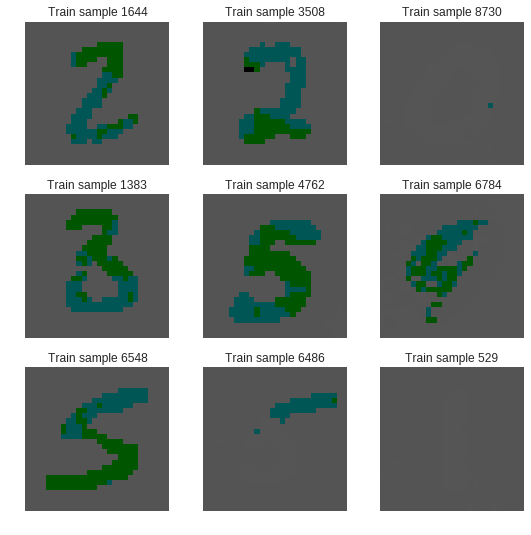

In [175]:
plt.figure(figsize=(9, 9))

for i in range(3):
    for j in range(3):
        plt.subplot(3, 3, i * 3 + j + 1)
        ind = np.random.choice(len(data['test']))
        plt.imshow(data['test'][ind] * 255 // 3)
        plt.title('Train sample {}'.format(ind))
        plt.axis('off')
        plt.grid(False)
plt.show()